## DATASET STATS

In [8]:
import pandas as pd

# Load the dataset
file_path = "/scratch/lcornelis/data/data_louisa/raw/ALLFTD_dataset_for_nina_louisa_071124_age_adjusted.csv"
data = pd.read_csv(file_path)

# Filter data for patients with HasCSF? == 1 and a value in NFL3_MEAN
filtered_data = data[(data['HasCSF?'] == 1) & (data['global.ageadj.slope'].notna())]

# Initialize a dictionary to store results
results = {}

# Group by Mutation
for mutation, group in filtered_data.groupby('Mutation'):
    sample_size = len(group)
    mean_age = group['AGE_AT_VISIT'].mean()
    std_age = group['AGE_AT_VISIT'].std()
    num_female = group[group['SEX_AT_BIRTH'] == 'F'].shape[0]
    percent_female = (num_female / sample_size) * 100
    
    # Count symptomatic and presymptomatic
    num_symptomatic = group['Gene.Dx'].str.contains('Sx').sum()
    num_presymptomatic = group['Gene.Dx'].str.contains('PreSx').sum()
    
    # Store results
    results[mutation] = {
        'Sample Size': sample_size,
        'Age, mean (SD)': f"{mean_age:.1f} ({std_age:.1f})",
        'Female, n (%)': f"{num_female} ({percent_female:.0f}%)",
        'Symptomatic': num_symptomatic,
        'Presymptomatic': num_presymptomatic
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

# Count columns ending with '|PLASMA'
plasma_columns = [col for col in data.columns if col.endswith('|PLASMA')]
num_plasma_columns = len(plasma_columns)

# Print the result
print(f"Number of columns ending with '|CSF': {num_plasma_columns}")

# Display the results
print(results_df)

/tmp/ipykernel_1531316/2791226305.py:5: DtypeWarning: Columns (14933,14939,14940,15012,15014,15015,15016,15017) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Number of columns ending with '|CSF': 7289
        Sample Size Age, mean (SD) Female, n (%) Symptomatic Presymptomatic
C9orf72          79    50.2 (13.5)      49 (62%)          79             41
CTL              84    44.7 (12.6)      43 (51%)           0              0
GRN              34    56.5 (13.4)      18 (53%)          34             16
MAPT             55    42.1 (13.1)      29 (53%)          55             33


## NFL PLOTS

Number of proteins present in both DataFrames: 7258


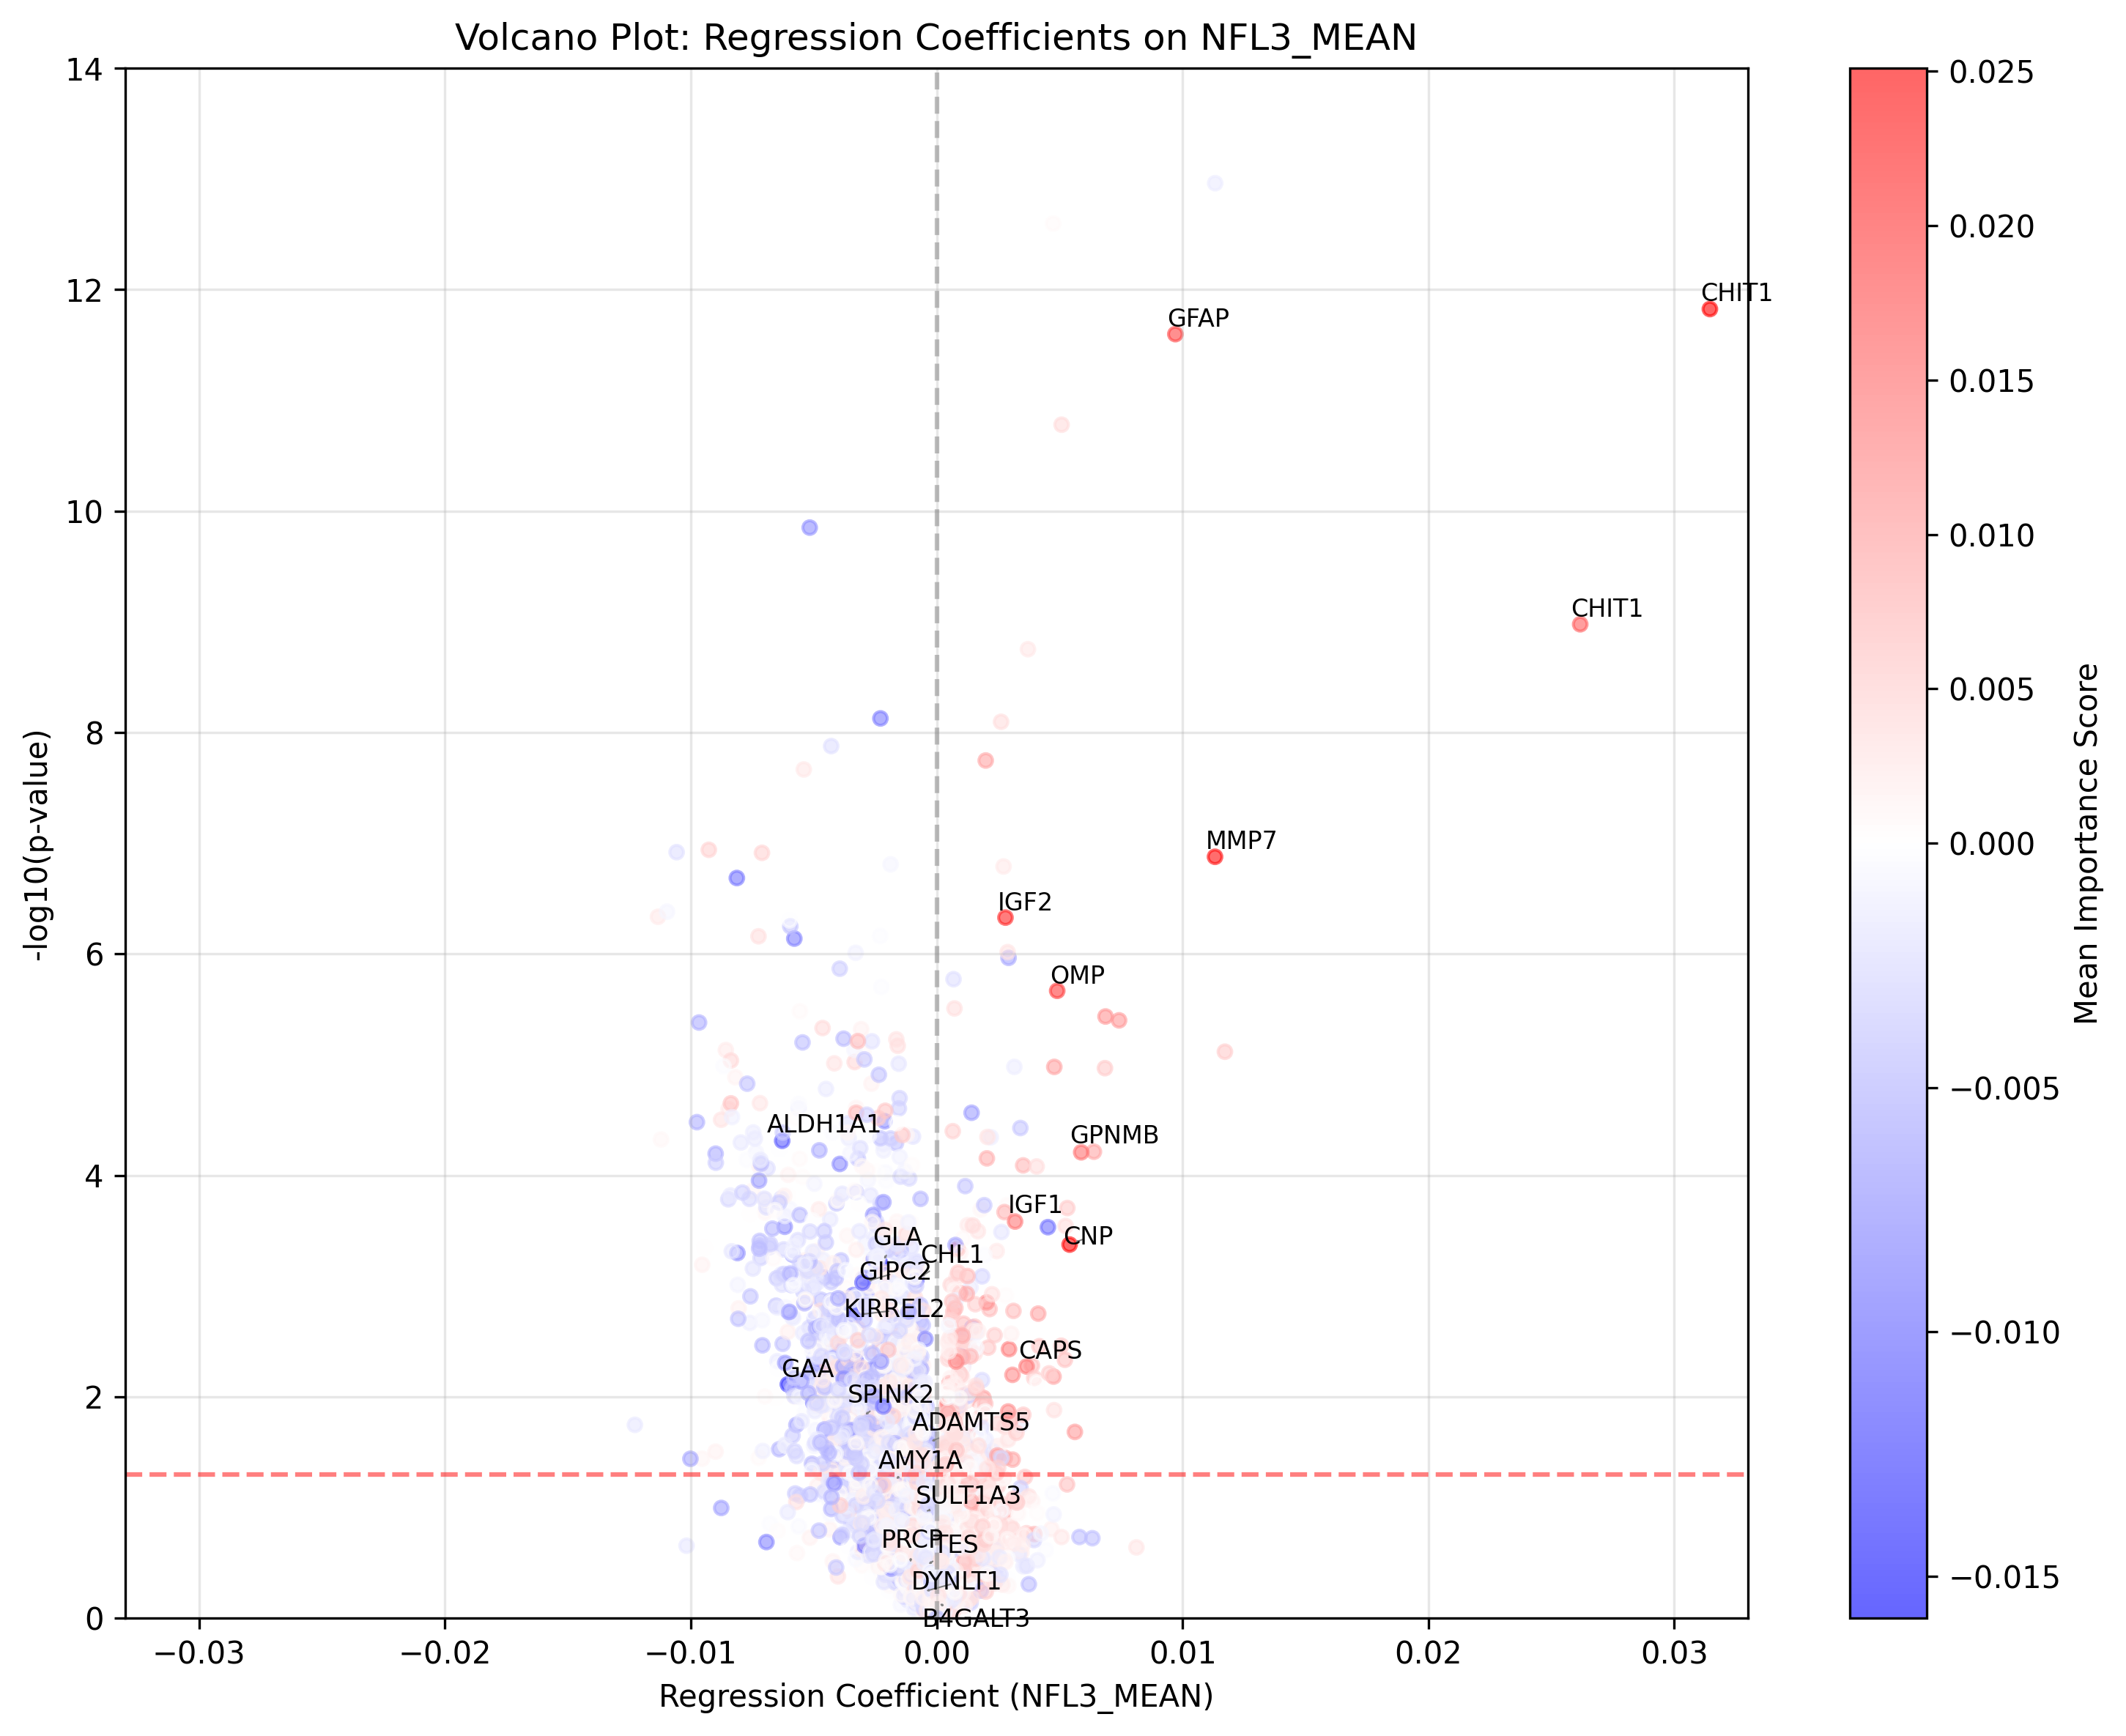


Top proteins with significant differential expression:
Empty DataFrame
Columns: [Coefficient, P_Value]
Index: []


In [2]:
!pip install adjustText
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from adjustText import adjust_text


# Load datasets
importance_scores = pd.read_csv("percent_importances_model=gat-v4,seed=47436_511_act=tanh,adj_thresh=0.9000,batch_size=8,dropout=0.1000,l1_lambda=0.0000,lr=0.0001,lr_scheduler=CosineA_2024-10-29_18-37-51.csv", index_col=0)
expression_values = pd.read_csv("raw_expression_nfl.csv", index_col=0)

nfl_data = pd.read_csv(
    "/scratch/lcornelis/data/data_louisa/raw/ALLFTD_dataset_for_nina_louisa_071124_age_adjusted.csv",
    index_col=0,
    low_memory=False
)

# Align NFL data with expression values using the index (PIDs)
nfl_data = nfl_data.loc[expression_values.index]

# Check if 'Mutation' column exists
if 'Mutation' in expression_values.columns:
    expression_values = pd.get_dummies(expression_values, columns=['Mutation'], drop_first=True)
else:
    print("Warning: 'Mutation' column not found in expression_values.")

# Use SEX, AGE, and Mutation from raw_expression
expression_values['SEX'] = expression_values['SEX'].map({'M': 0, 'F': 1})

# Ensure NFL3_MEAN is aligned
expression_values['NFL3_MEAN'] = nfl_data['NFL3_MEAN']

# Convert importance_scores to numeric, ignoring errors
importance_scores = importance_scores.apply(pd.to_numeric, errors='coerce')

# Extract protein columns from importance_scores, starting from the 5th column
protein_columns = importance_scores.columns[4:]

# Filter protein columns that are present in both DataFrames
common_proteins = [col for col in protein_columns if col in expression_values.columns]

# Print the number of proteins present in both DataFrames
print(f"Number of proteins present in both DataFrames: {len(common_proteins)}")

# Initialize dictionaries for results
coefficients = {}
p_values = {}

# Calculate regression coefficients and p-values for each protein
for protein in common_proteins:
    X = expression_values[['NFL3_MEAN', 'AGE', 'SEX'] + [col for col in expression_values.columns if col.startswith('Mutation_')]].values
    y = expression_values[protein].values
    
    # Fit linear regression model
    model = LinearRegression().fit(X, y)
    coef = model.coef_[0]  # Coefficient for NFL3_MEAN
    coefficients[protein] = coef
    
    # Calculate p-value for NFL3_MEAN coefficient
    predictions = model.predict(X)
    residuals = y - predictions
    sse = np.sum(residuals**2)
    df_residuals = len(y) - X.shape[1] - 1
    mse = sse / df_residuals
    se = np.sqrt(mse / np.sum((X[:, 0] - np.mean(X[:, 0]))**2))
    t_stat = coef / se
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df_residuals))
    p_values[protein] = p_value

# Ensure the lengths match
coefficients_series = pd.Series(coefficients)
p_values_series = pd.Series(p_values)

mean_importance = importance_scores[common_proteins].mean(axis=0)

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'Coefficient': coefficients_series,
    'P_Value': p_values_series,
    'Mean_Importance': mean_importance
})

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'white', 'red'])

# Use TwoSlopeNorm to center the colormap at 0
norm = TwoSlopeNorm(vmin=mean_importance.min(), vcenter=0, vmax=mean_importance.max())

# Plotting
plt.figure(figsize=(10, 8), dpi=300)
scatter = plt.scatter(
    volcano_df['Coefficient'],
    -np.log10(volcano_df['P_Value']),
    c=volcano_df['Mean_Importance'],
    cmap=cmap,
    norm=norm,
    alpha=0.6,
    s=20
)

# Label top 10 most positive and top 10 most negative Mean Importance values
texts = []
top_positive = volcano_df.nlargest(12, 'Mean_Importance')
top_negative = volcano_df.nsmallest(12, 'Mean_Importance')

for i, row in pd.concat([top_positive, top_negative]).iterrows():
    protein_name = i.split('|')[0]  # Extract text before '|'
    texts.append(plt.text(row['Coefficient'], -np.log10(row['P_Value']), protein_name, fontsize=8))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

plt.colorbar(scatter, label='Mean Importance Score')
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.5)
plt.xlabel('Regression Coefficient (NFL3_MEAN)')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot: Regression Coefficients on NFL3_MEAN')
plt.xlim(-0.033, 0.033)  # Adjusted x-axis limits
plt.ylim(0, 14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print significant results
significant_threshold = 0.05
volcano_df['Significant'] = volcano_df['P_Value'] < significant_threshold
significant_proteins = volcano_df[
    (volcano_df['Significant']) & 
    (abs(volcano_df['Coefficient']) > 0.5)
].sort_values('P_Value')

print("\nTop proteins with significant differential expression:")
print(significant_proteins[['Coefficient', 'P_Value']].head(10))

Number of proteins present in both DataFrames: 7258


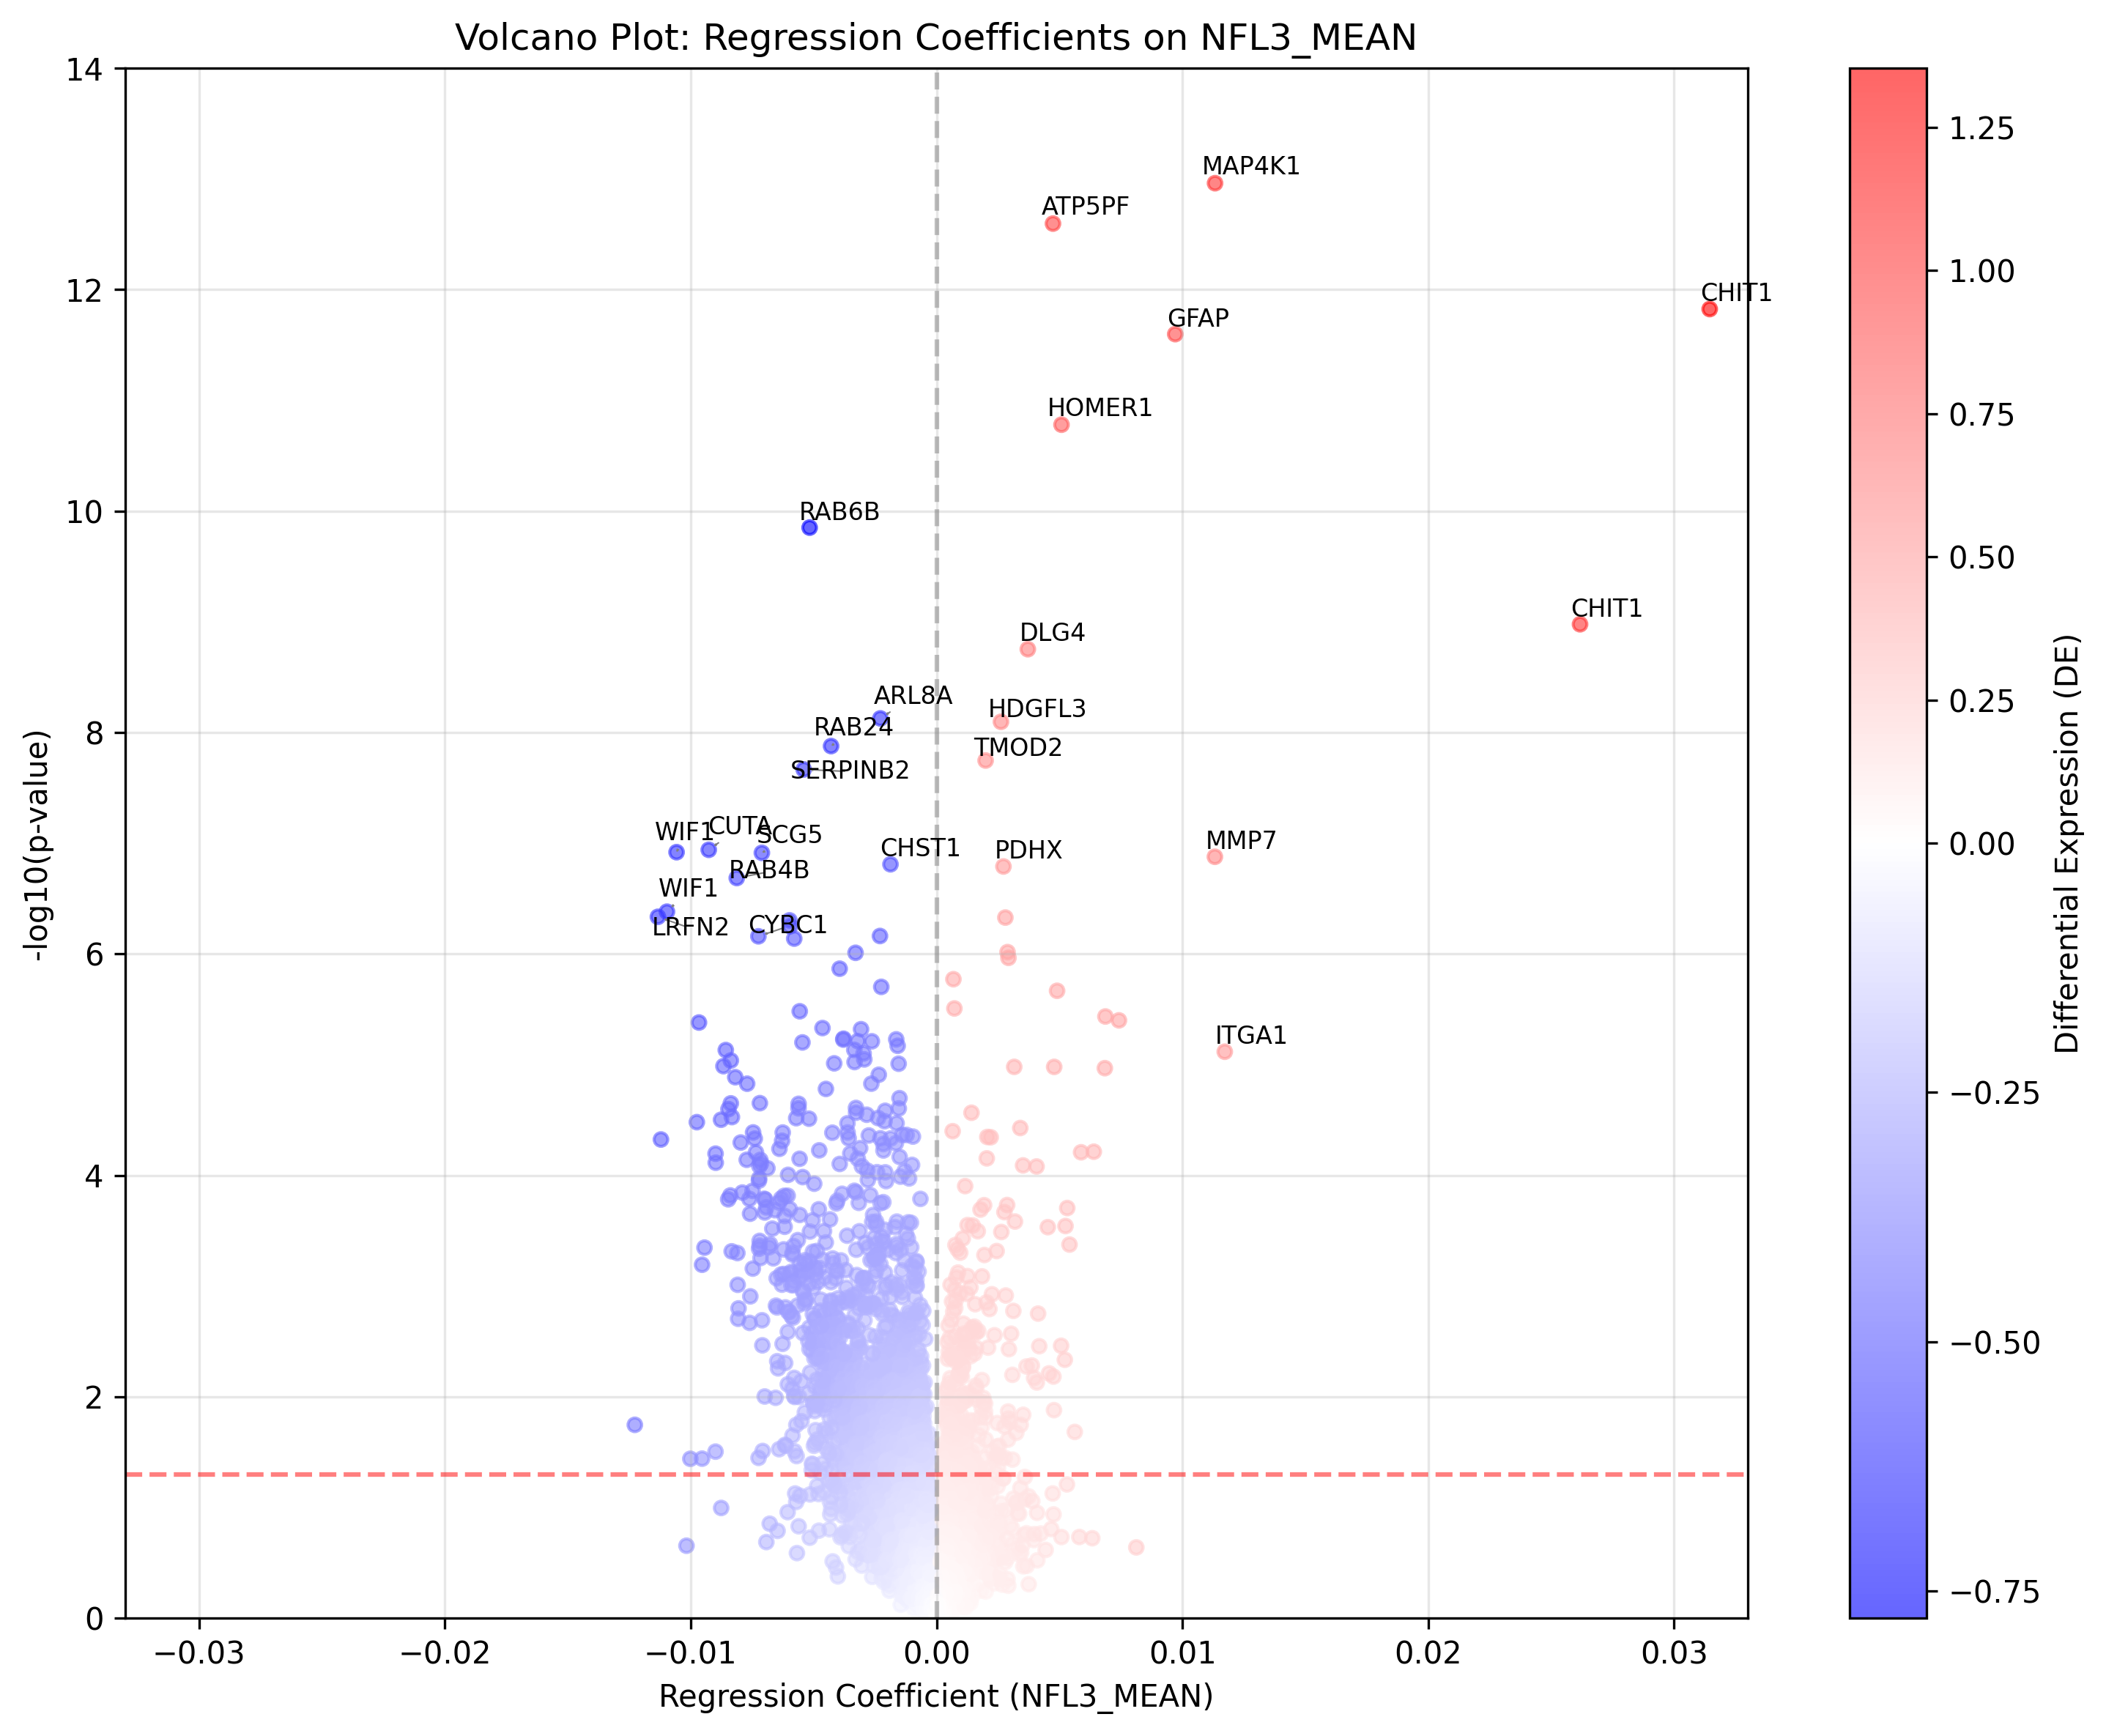


Top proteins with significant differential expression:
Empty DataFrame
Columns: [Coefficient, P_Value]
Index: []


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from adjustText import adjust_text

# Load datasets
importance_scores = pd.read_csv("percent_importances_model=gat-v4,seed=47436_511_act=tanh,adj_thresh=0.9000,batch_size=8,dropout=0.1000,l1_lambda=0.0000,lr=0.0001,lr_scheduler=CosineA_2024-10-29_18-37-51.csv", index_col=0)
expression_values = pd.read_csv("raw_expression_nfl.csv", index_col=0)

nfl_data = pd.read_csv(
    "/scratch/lcornelis/data/data_louisa/raw/ALLFTD_dataset_for_nina_louisa_071124_age_adjusted.csv",
    index_col=0,
    low_memory=False
)

# Align NFL data with expression values using the index (PIDs)
nfl_data = nfl_data.loc[expression_values.index]

# Check if 'Mutation' column exists
if 'Mutation' in expression_values.columns:
    expression_values = pd.get_dummies(expression_values, columns=['Mutation'], drop_first=True)
else:
    print("Warning: 'Mutation' column not found in expression_values.")

# Use SEX, AGE, and Mutation from raw_expression
expression_values['SEX'] = expression_values['SEX'].map({'M': 0, 'F': 1})

# Ensure NFL3_MEAN is aligned
expression_values['NFL3_MEAN'] = nfl_data['NFL3_MEAN']

# Convert importance_scores to numeric, ignoring errors
importance_scores = importance_scores.apply(pd.to_numeric, errors='coerce')

# Extract protein columns from importance_scores, starting from the 5th column
protein_columns = importance_scores.columns[4:]

# Filter protein columns that are present in both DataFrames
common_proteins = [col for col in protein_columns if col in expression_values.columns]

# Print the number of proteins present in both DataFrames
print(f"Number of proteins present in both DataFrames: {len(common_proteins)}")

# Initialize dictionaries for results
coefficients = {}
p_values = {}

# Calculate regression coefficients and p-values for each protein
for protein in common_proteins:
    X = expression_values[['NFL3_MEAN', 'AGE', 'SEX'] + [col for col in expression_values.columns if col.startswith('Mutation_')]].values
    y = expression_values[protein].values
    
    # Fit linear regression model
    model = LinearRegression().fit(X, y)
    coef = model.coef_[0]  # Coefficient for NFL3_MEAN
    coefficients[protein] = coef
    
    # Calculate p-value for NFL3_MEAN coefficient
    predictions = model.predict(X)
    residuals = y - predictions
    sse = np.sum(residuals**2)
    df_residuals = len(y) - X.shape[1] - 1
    mse = sse / df_residuals
    se = np.sqrt(mse / np.sum((X[:, 0] - np.mean(X[:, 0]))**2))
    t_stat = coef / se
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df_residuals))
    p_values[protein] = p_value

# Ensure the lengths match
coefficients_series = pd.Series(coefficients)
p_values_series = pd.Series(p_values)

# Calculate DE for each protein
max_coef = coefficients_series.abs().max()
min_log_p_value = np.log(p_values_series).min()

DE = np.sqrt(
    (coefficients_series / max_coef) ** 2 +
    (np.log(p_values_series) / min_log_p_value) ** 2
)

# Sign the DE values
signed_DE = DE * np.sign(coefficients_series)

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'Coefficient': coefficients_series,
    'P_Value': p_values_series,
    'DE': signed_DE
})

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'white', 'red'])
# Use TwoSlopeNorm to center the colormap at 0
norm = TwoSlopeNorm(vmin=signed_DE.min(), vcenter=0, vmax=signed_DE.max())

# Plotting
plt.figure(figsize=(10, 8), dpi=300)
scatter = plt.scatter(
    volcano_df['Coefficient'],
    -np.log10(volcano_df['P_Value']),
    c=volcano_df['DE'],
    cmap=cmap,
    norm=norm,
    alpha=0.6,
    s=20
)

# Label top 10 most positive and top 10 most negative DE values
texts = []
top_positive = volcano_df.nlargest(12, 'DE')
top_negative = volcano_df.nsmallest(12, 'DE')

for i, row in pd.concat([top_positive, top_negative]).iterrows():
    protein_name = i.split('|')[0]  # Extract text before '|'
    texts.append(plt.text(row['Coefficient'], -np.log10(row['P_Value']), protein_name, fontsize=8))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

plt.colorbar(scatter, label='Differential Expression (DE)')
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.5)
plt.xlabel('Regression Coefficient (NFL3_MEAN)')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot: Regression Coefficients on NFL3_MEAN')
plt.xlim(-0.033, 0.033)  # Adjusted x-axis limits
plt.ylim(0, 14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print significant results
significant_threshold = 0.05
volcano_df['Significant'] = volcano_df['P_Value'] < significant_threshold
significant_proteins = volcano_df[
    (volcano_df['Significant']) & 
    (abs(volcano_df['Coefficient']) > 0.5)
].sort_values('P_Value')

print("\nTop proteins with significant differential expression:")
print(significant_proteins[['Coefficient', 'P_Value']].head(10))

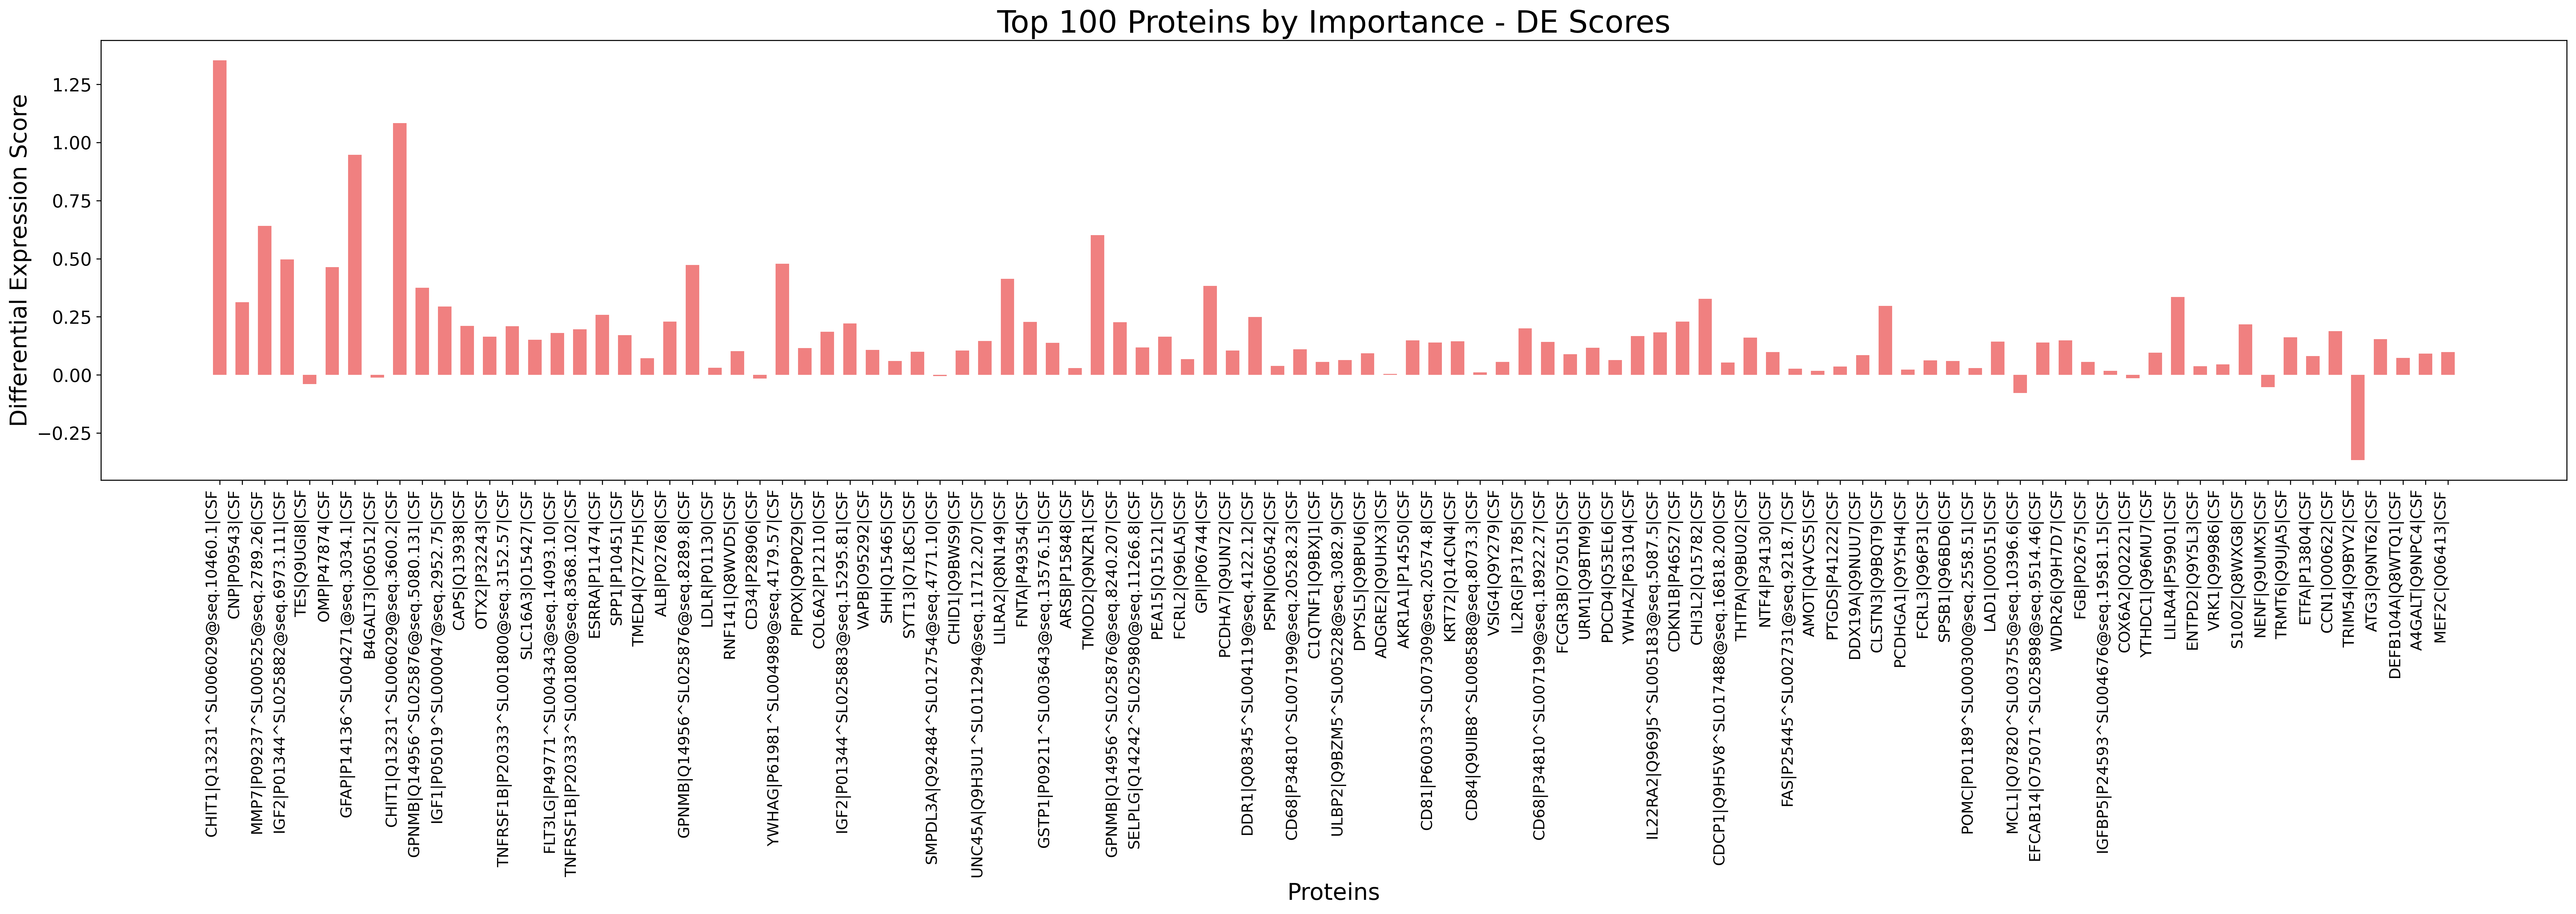

In [4]:
import matplotlib.pyplot as plt

# Assuming `mean_importance` and `signed_DE` are pandas Series with protein names as indices
# Align DE scores with the order of mean importance scores
aligned_DE = signed_DE.reindex(mean_importance.index)

# Extract the top N proteins based on mean importance
top_n = 100  # or any number you choose
top_proteins = mean_importance.nlargest(top_n).index

# Get the DE scores for these top proteins
x_highest = top_proteins
y_highest = aligned_DE.loc[top_proteins]

# Plotting
plt.figure(figsize=(28, 10), dpi=300)
bar_width = 0.6
plt.bar(x_highest, y_highest, color='lightcoral', width=bar_width)
plt.xlabel("Proteins", fontsize=18)
plt.ylabel("Differential Expression Score", fontsize=18)
plt.title(f"Top {top_n} Proteins by Importance - DE Scores", fontsize=24)
plt.xticks(rotation=90, ha='right', fontsize=12)
plt.yticks(fontsize=14)
plt.tight_layout()

# Save the plot if a filename is provided
filename = "de_scores_plot"  # Change this to your desired filename
plt.savefig(f"{filename}_highest.png")

plt.show()

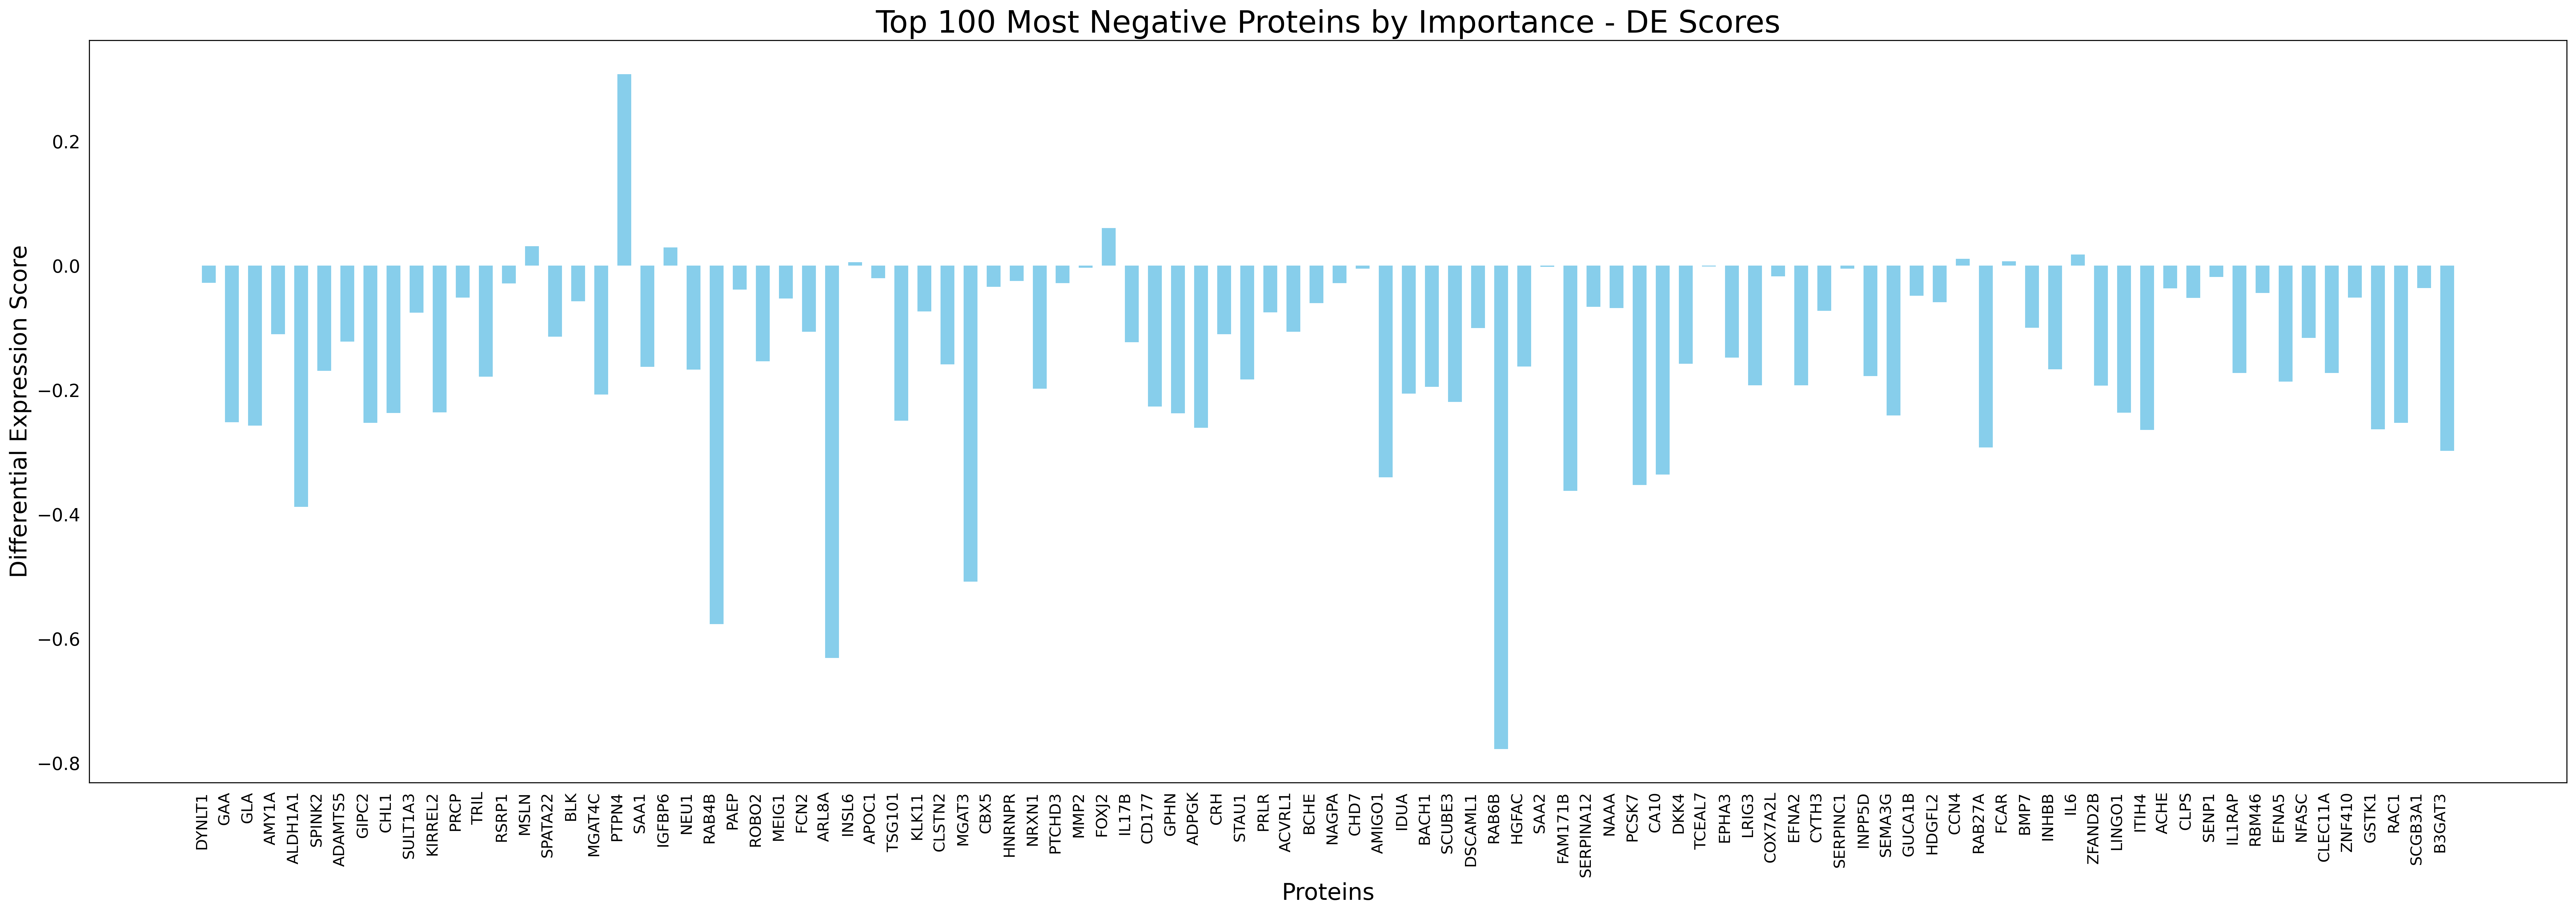

In [5]:
import matplotlib.pyplot as plt

# Assuming `mean_importance` and `signed_DE` are pandas Series with protein names as indices
# Align DE scores with the order of mean importance scores
aligned_DE = signed_DE.reindex(mean_importance.index)

# Extract the top N most negative proteins based on mean importance
top_n = 100  # or any number you choose
bottom_proteins = mean_importance.nsmallest(top_n).index

# Get the DE scores for these bottom proteins
x_lowest = [protein.split('|')[0] for protein in bottom_proteins]  # Extract text before '|'
y_lowest = aligned_DE.loc[bottom_proteins]

# Plotting
plt.figure(figsize=(28, 10), dpi=300)
bar_width = 0.6
plt.bar(x_lowest, y_lowest, color='skyblue', width=bar_width)
plt.xlabel("Proteins", fontsize=18)
plt.ylabel("Differential Expression Score", fontsize=18)
plt.title(f"Top {top_n} Most Negative Proteins by Importance - DE Scores", fontsize=24)
plt.xticks(rotation=90, ha='right', fontsize=12)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', bottom=False, left=False)  # Remove ticks from both axes
plt.tight_layout()

# Save the plot if a filename is provided
filename = "negative_de_scores_plot"  # Change this to your desired filename
plt.savefig(f"{filename}_lowest.png")

plt.show()

## GLOBAL AGE PLOTS

Number of proteins present in both DataFrames: 7257


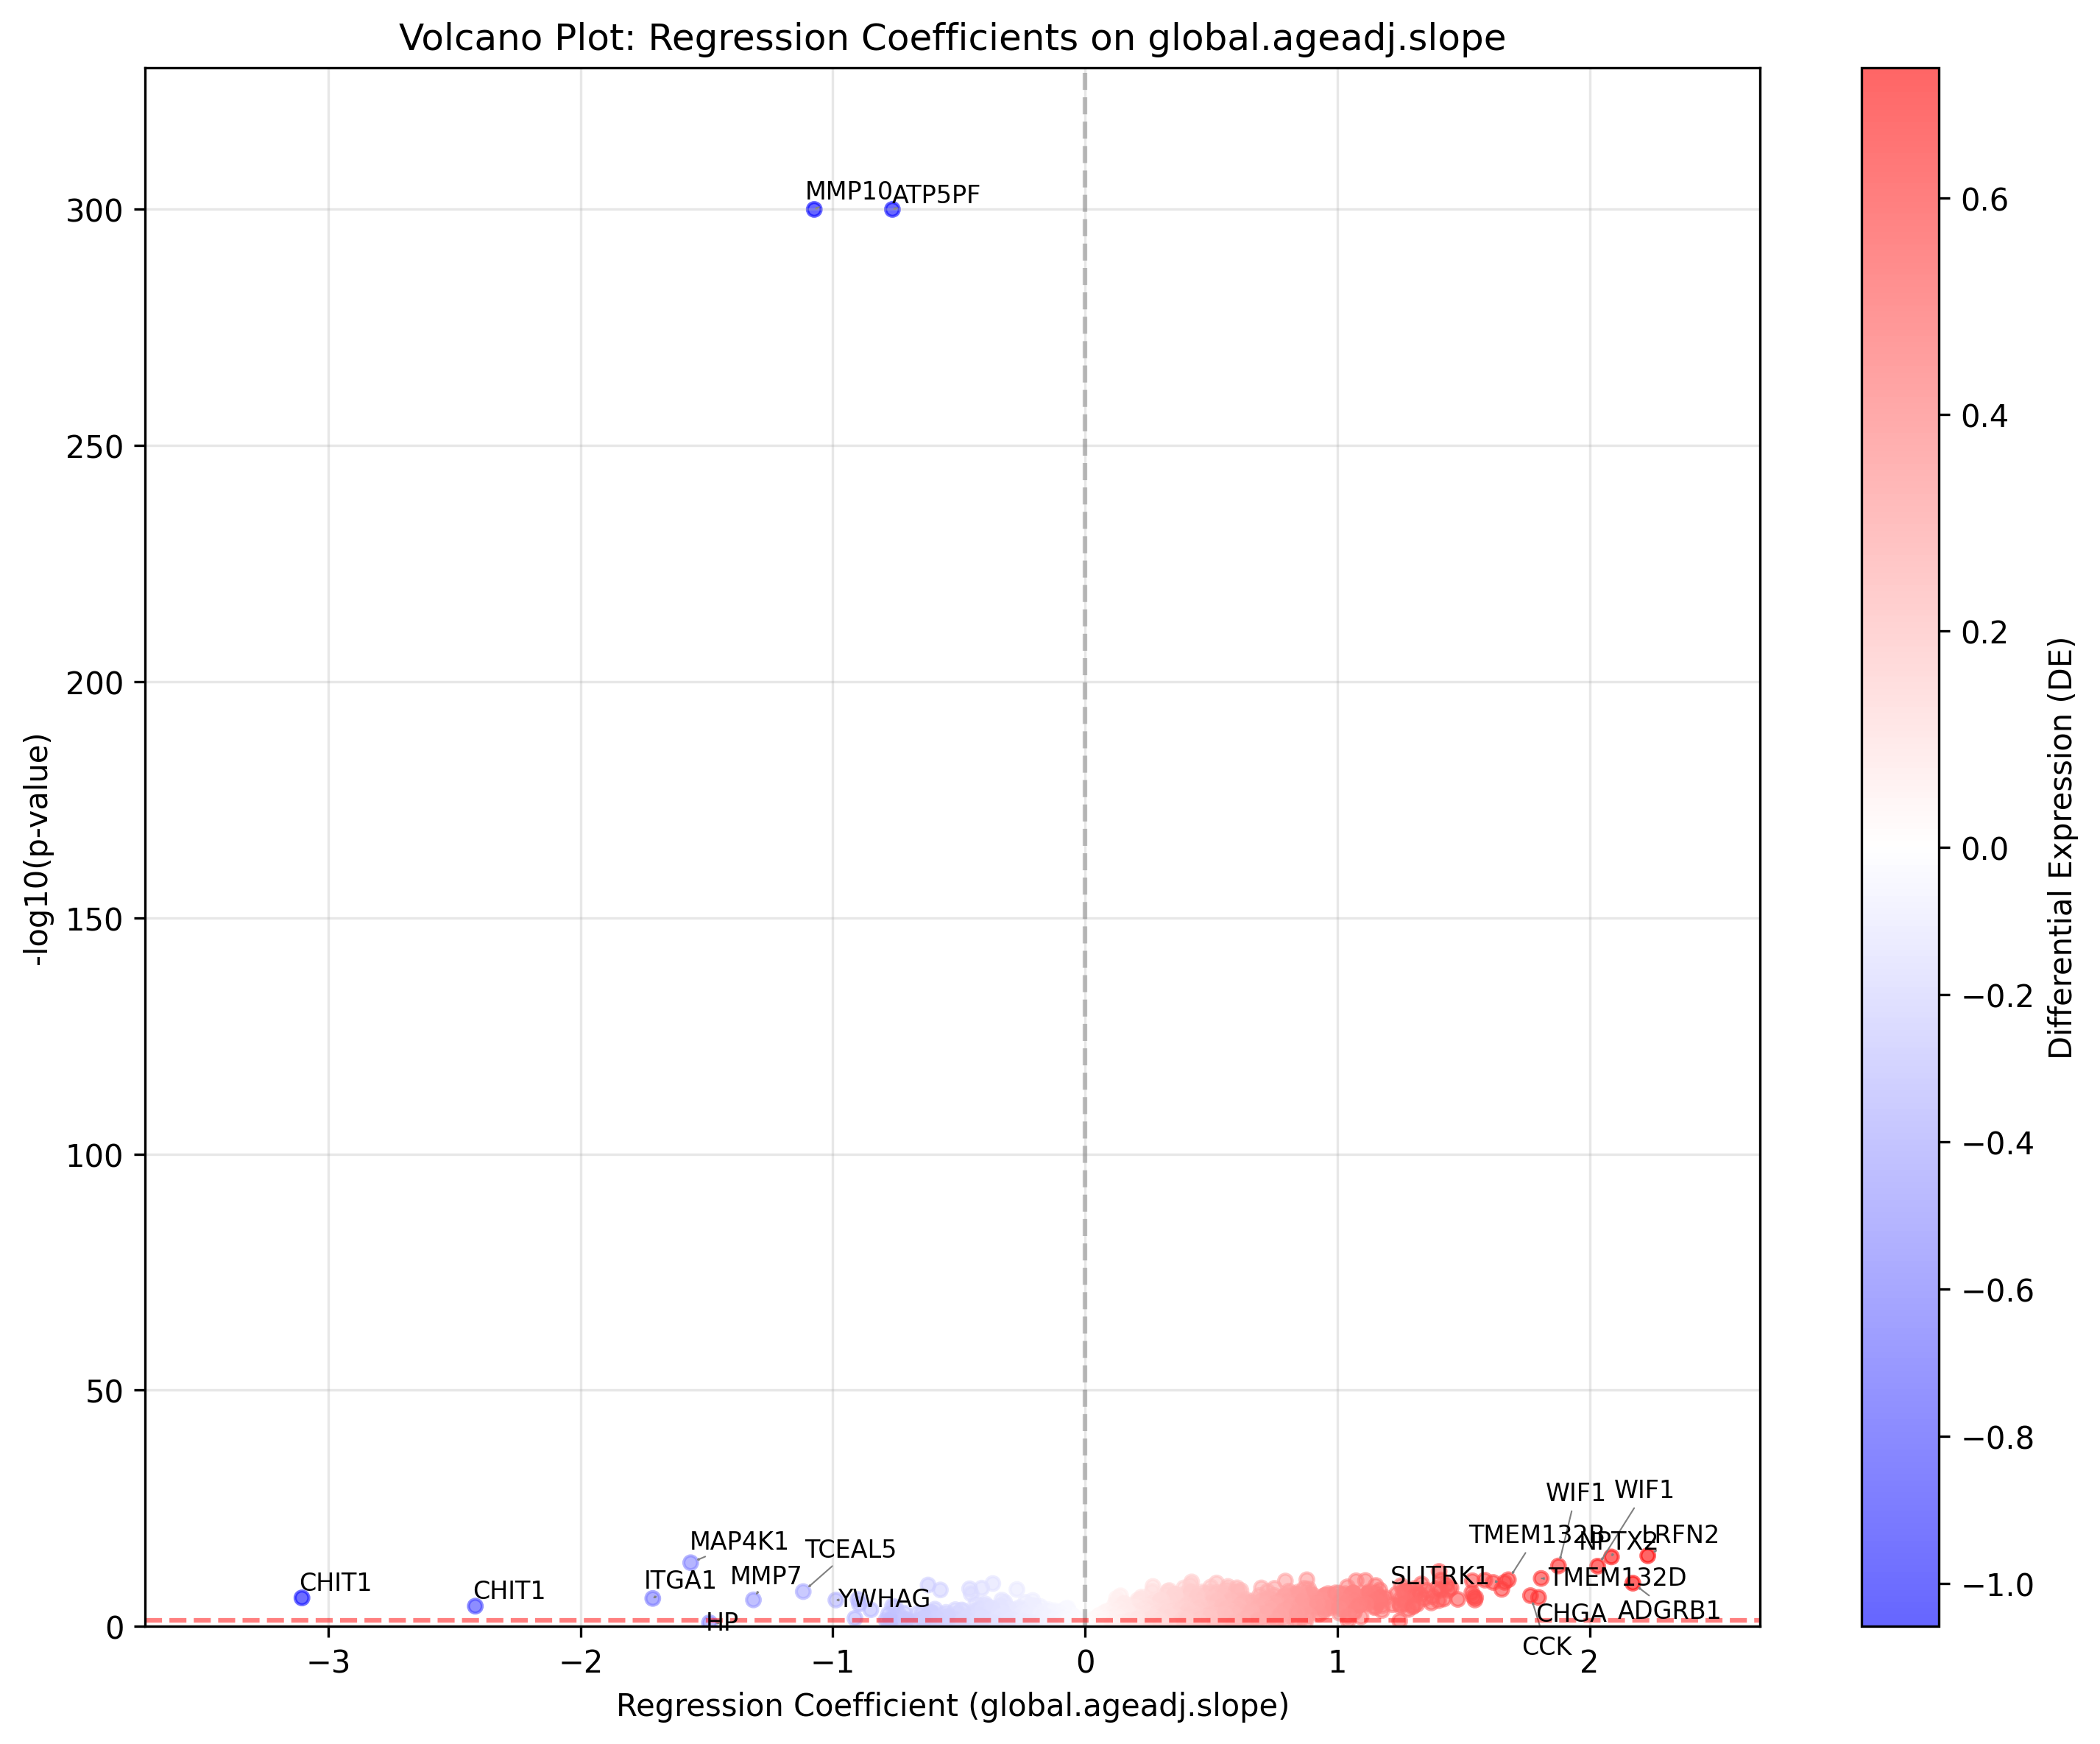


Top proteins with significant differential expression:
                                        Coefficient        P_Value
MMP10|P09238^SL000645@seq.10479.18|CSF    -1.073657  1.000000e-300
ATP5PF|P18859|CSF                         -0.763791  1.000000e-300
LRFN2|Q9ULH4|CSF                           2.230277   1.110223e-15
NPTX2|P47972|CSF                           2.086244   1.998401e-15
MAP4K1|Q92918|CSF                         -1.563384   3.397282e-14
WIF1|Q9Y5W5^SL004652@seq.2848.2|CSF        1.876250   1.649791e-13
WIF1|Q9Y5W5^SL004652@seq.16070.7|CSF       2.031616   1.798561e-13
NPTXR|O95502^SL008970@seq.15511.37|CSF     1.403092   2.299272e-12
TMEM132D|Q14C87|CSF                        1.807779   7.257595e-11
TMEM132B|Q14DG7|CSF                        1.677708   1.330986e-10


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from adjustText import adjust_text

# Load datasets
importance_scores = pd.read_csv("percent_importances_model=gat-v4,seed=42423_3995_act=sigmoid,adj_thresh=0.7000,batch_size=32,dropout=0.2000,l1_lambda=0.0000,lr=0.0087,lr_scheduler=La_2025-02-05_12-48-31.csv", index_col=0)
expression_values = pd.read_csv("raw_expression_global_age.csv", index_col=0)

nfl_data = pd.read_csv(
    "/scratch/lcornelis/data/data_louisa/raw/ALLFTD_dataset_for_nina_louisa_071124_age_adjusted.csv",
    index_col=0,
    low_memory=False
)

# Align NFL data with expression values using the index (PIDs)
nfl_data = nfl_data.loc[expression_values.index]

# Check if 'Mutation' column exists
if 'Mutation' in expression_values.columns:
    expression_values = pd.get_dummies(expression_values, columns=['Mutation'], drop_first=True)
else:
    print("Warning: 'Mutation' column not found in expression_values.")

# Use SEX, AGE, and Mutation from raw_expression
expression_values['SEX'] = expression_values['SEX'].map({'M': 0, 'F': 1})

# Ensure global.ageadj.slope is aligned
expression_values['global.ageadj.slope'] = nfl_data['global.ageadj.slope']

# Convert importance_scores to numeric, ignoring errors
importance_scores = importance_scores.apply(pd.to_numeric, errors='coerce')

# Extract protein columns from importance_scores, starting from the 5th column
protein_columns = importance_scores.columns[4:]

# Filter protein columns that are present in both DataFrames
common_proteins = [col for col in protein_columns if col in expression_values.columns]

# Print the number of proteins present in both DataFrames
print(f"Number of proteins present in both DataFrames: {len(common_proteins)}")

# Initialize dictionaries for results
coefficients = {}
p_values = {}

# Calculate regression coefficients and p-values for each protein
for protein in common_proteins:
    X = expression_values[['global.ageadj.slope', 'AGE', 'SEX'] + [col for col in expression_values.columns if col.startswith('Mutation_')]].values
    y = expression_values[protein].values
    
    # Fit linear regression model
    model = LinearRegression().fit(X, y)
    coef = model.coef_[0]  # Coefficient for global.ageadj.slope
    coefficients[protein] = coef
    
    # Calculate p-value for global.ageadj.slope coefficient
    predictions = model.predict(X)
    residuals = y - predictions
    sse = np.sum(residuals**2)
    df_residuals = len(y) - X.shape[1] - 1
    mse = sse / df_residuals
    se = np.sqrt(mse / np.sum((X[:, 0] - np.mean(X[:, 0]))**2))
    t_stat = coef / se
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df_residuals))
    p_values[protein] = p_value

# Ensure the lengths match
coefficients_series = pd.Series(coefficients)
p_values_series = pd.Series(p_values)

# Avoid log(0) errors
p_values_series = p_values_series.replace(0, 1e-300)

# Calculate DE for each protein
max_coef = coefficients_series.abs().max()
min_log_p_value = np.log(p_values_series).min()

DE = np.sqrt(
    (coefficients_series / max_coef) ** 2 +
    (np.log(p_values_series) / min_log_p_value) ** 2
)

# Sign the DE values
signed_DE = DE * np.sign(coefficients_series)

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'Coefficient': coefficients_series,
    'P_Value': p_values_series,
    'DE': signed_DE
})

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'white', 'red'])

# Use TwoSlopeNorm to center the colormap at 0
norm = TwoSlopeNorm(vmin=signed_DE.min(), vcenter=0, vmax=signed_DE.max())

# Plotting
plt.figure(figsize=(10, 8), dpi=300)
scatter = plt.scatter(
    volcano_df['Coefficient'],
    -np.log10(volcano_df['P_Value']),
    c=volcano_df['DE'],
    cmap=cmap,
    norm=norm,
    alpha=0.6,
    s=20
)

# Label top 10 most positive and top 10 most negative DE values
texts = []
top_positive = volcano_df.nlargest(10, 'DE')
top_negative = volcano_df.nsmallest(10, 'DE')

for i, row in pd.concat([top_positive, top_negative]).iterrows():
    protein_name = i.split('|')[0]  # Extract text before '|'
    texts.append(plt.text(row['Coefficient'], -np.log10(row['P_Value']), protein_name, fontsize=8))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

plt.colorbar(scatter, label='Differential Expression (DE)')
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.5)
plt.xlabel('Regression Coefficient (global.ageadj.slope)')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot: Regression Coefficients on global.ageadj.slope')
plt.xlim(volcano_df['Coefficient'].min() * 1.2, volcano_df['Coefficient'].max() * 1.2)
plt.ylim(0, np.max(-np.log10(volcano_df['P_Value'])) * 1.1) 
plt.grid(True, alpha=0.3)

plt.tight_layout()  # Auto-fixes the spacing

plt.show()

# Print significant results
significant_threshold = 0.05
volcano_df['Significant'] = volcano_df['P_Value'] < significant_threshold
significant_proteins = volcano_df[
    (volcano_df['Significant']) & 
    (abs(volcano_df['Coefficient']) > 0.5)
].sort_values('P_Value')

print("\nTop proteins with significant differential expression:")
print(significant_proteins[['Coefficient', 'P_Value']].head(10))

Number of proteins present in both DataFrames: 7257


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


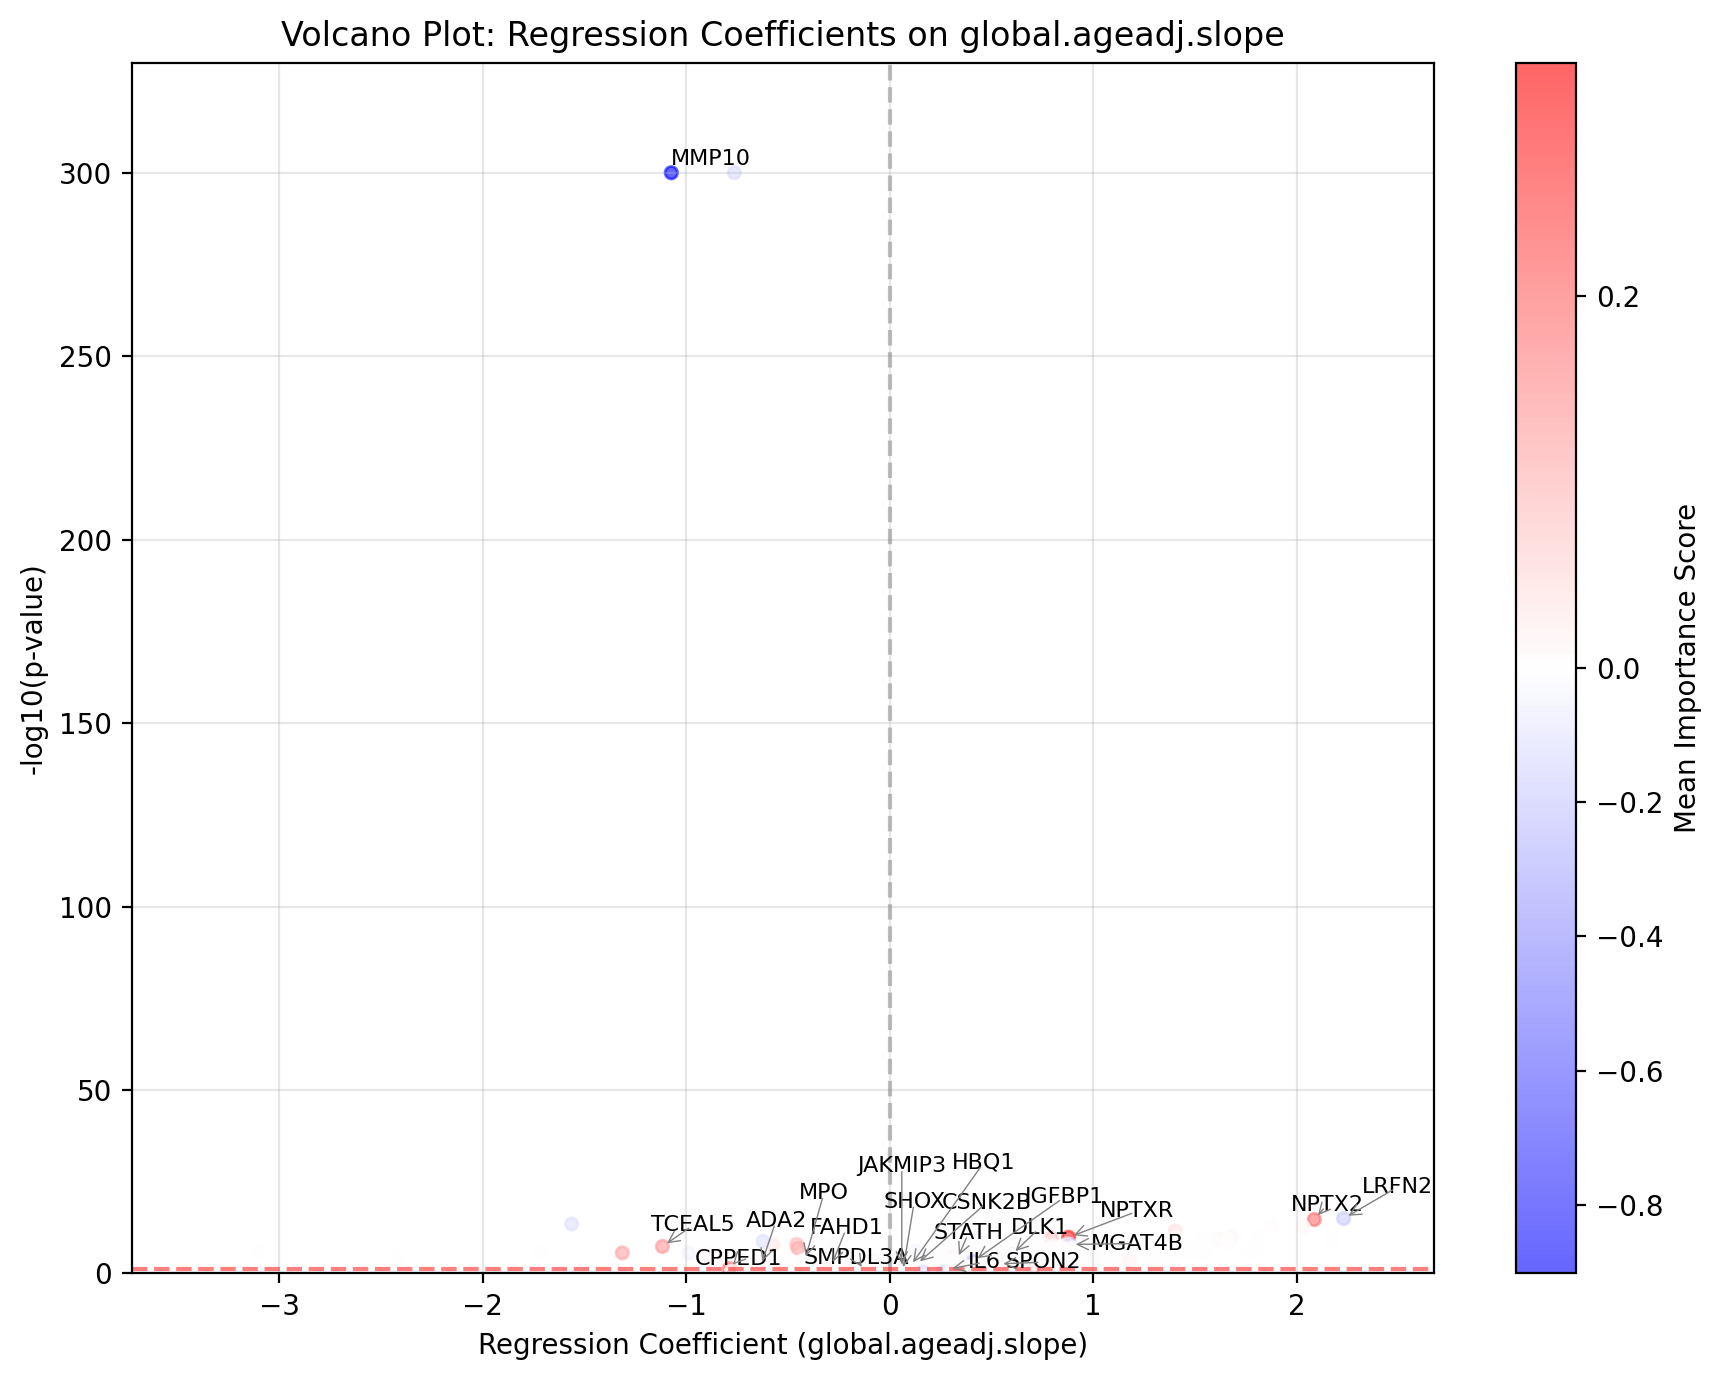


Top proteins with significant differential expression:
                                        Coefficient        P_Value
MMP10|P09238^SL000645@seq.10479.18|CSF    -1.073657  1.000000e-300
ATP5PF|P18859|CSF                         -0.763791  1.000000e-300
LRFN2|Q9ULH4|CSF                           2.230277   1.110223e-15
NPTX2|P47972|CSF                           2.086244   1.998401e-15
MAP4K1|Q92918|CSF                         -1.563384   3.397282e-14
WIF1|Q9Y5W5^SL004652@seq.2848.2|CSF        1.876250   1.649791e-13
WIF1|Q9Y5W5^SL004652@seq.16070.7|CSF       2.031616   1.798561e-13
NPTXR|O95502^SL008970@seq.15511.37|CSF     1.403092   2.299272e-12
TMEM132D|Q14C87|CSF                        1.807779   7.257595e-11
TMEM132B|Q14DG7|CSF                        1.677708   1.330986e-10


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from adjustText import adjust_text

# Load datasets
importance_scores = pd.read_csv("percent_importances_model=gat-v4,seed=42423_3995_act=sigmoid,adj_thresh=0.7000,batch_size=32,dropout=0.2000,l1_lambda=0.0000,lr=0.0087,lr_scheduler=La_2025-02-05_12-48-31.csv", index_col=0)
expression_values = pd.read_csv("raw_expression_global_age.csv", index_col=0)

nfl_data = pd.read_csv(
    "/scratch/lcornelis/data/data_louisa/raw/ALLFTD_dataset_for_nina_louisa_071124_age_adjusted.csv",
    index_col=0,
    low_memory=False
)

# Align NFL data with expression values using the index (PIDs)
nfl_data = nfl_data.loc[expression_values.index]

# Check if 'Mutation' column exists
if 'Mutation' in expression_values.columns:
    expression_values = pd.get_dummies(expression_values, columns=['Mutation'], drop_first=True)
else:
    print("Warning: 'Mutation' column not found in expression_values.")

# Use SEX, AGE, and Mutation from raw_expression
expression_values['SEX'] = expression_values['SEX'].map({'M': 0, 'F': 1})

# Ensure global.ageadj.slope is aligned
expression_values['global.ageadj.slope'] = nfl_data['global.ageadj.slope']

# Convert importance_scores to numeric, ignoring errors
importance_scores = importance_scores.apply(pd.to_numeric, errors='coerce')

# Extract protein columns from importance_scores, starting from the 5th column
protein_columns = importance_scores.columns[4:]

# Filter protein columns that are present in both DataFrames
common_proteins = [col for col in protein_columns if col in expression_values.columns]

print(f"Number of proteins present in both DataFrames: {len(common_proteins)}")

# Initialize dictionaries for results
coefficients = {}
p_values = {}

# Calculate regression coefficients and p-values for each protein
for protein in common_proteins:
    X = expression_values[['global.ageadj.slope', 'AGE', 'SEX'] + [col for col in expression_values.columns if col.startswith('Mutation_')]].values
    y = expression_values[protein].values
    
    # Fit linear regression model
    model = LinearRegression().fit(X, y)
    coef = model.coef_[0]  # Coefficient for global.ageadj.slope
    coefficients[protein] = coef
    
    # Calculate p-value for global.ageadj.slope coefficient
    predictions = model.predict(X)
    residuals = y - predictions
    sse = np.sum(residuals**2)
    df_residuals = len(y) - X.shape[1] - 1
    mse = sse / df_residuals
    se = np.sqrt(mse / np.sum((X[:, 0] - np.mean(X[:, 0]))**2))
    t_stat = coef / se
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df_residuals))
    p_values[protein] = p_value

# Convert results to Pandas Series
coefficients_series = pd.Series(coefficients)
p_values_series = pd.Series(p_values)

# ✅ Fix: Replace zero p-values to prevent log(0) errors
p_values_series = p_values_series.replace(0, 1e-300)

# ✅ Compute Mean Importance Score
mean_importance = importance_scores[common_proteins].mean(axis=0)

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'Coefficient': coefficients_series,
    'P_Value': p_values_series,
    'Mean_Importance': mean_importance
})

# ✅ Fix: Create a custom colormap for Mean Importance Score
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'white', 'red'])
norm = TwoSlopeNorm(vmin=mean_importance.min(), vcenter=0, vmax=mean_importance.max())

# ✅ Fix: Adjust Figure Size
plt.figure(figsize=(9, 7), dpi=200)

# ✅ Fix: Scatter Plot with Mean Importance Score as Color
scatter = plt.scatter(
    volcano_df['Coefficient'],
    -np.log10(volcano_df['P_Value']),
    c=volcano_df['Mean_Importance'],
    cmap=cmap,
    norm=norm,
    alpha=0.6,
    s=20
)

# ✅ Fix: Y-axis limits to avoid Inf errors
max_log_p = np.max(-np.log10(volcano_df['P_Value']))  # Compute max safely
plt.ylim(0, max_log_p * 1.1)

# ✅ Fix: Proper X-axis limits
plt.xlim(volcano_df['Coefficient'].min() * 1.2, volcano_df['Coefficient'].max() * 1.2)

# ✅ Fix: Label Top 10 Most Positive & Negative Mean Importance values
texts = []
top_positive = volcano_df.nlargest(10, 'Mean_Importance')
top_negative = volcano_df.nsmallest(10, 'Mean_Importance')

for i, row in pd.concat([top_positive, top_negative]).iterrows():
    if np.isfinite(row['Coefficient']) and np.isfinite(-np.log10(row['P_Value'])):
        protein_name = i.split('|')[0]  # Extract text before '|'
        texts.append(plt.text(row['Coefficient'], -np.log10(row['P_Value']), protein_name, fontsize=8))

# ✅ Fix: Adjust text placement
adjust_text(texts, expand_text=(1.2, 1.3), arrowprops=dict(arrowstyle="->", color="gray", lw=0.5))

# ✅ Fix: Add colorbar, grid, and annotations
plt.colorbar(scatter, label='Mean Importance Score')
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.5)
plt.xlabel('Regression Coefficient (global.ageadj.slope)')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot: Regression Coefficients on global.ageadj.slope')

plt.grid(True, alpha=0.3)

# ✅ Fix: Use `plt.tight_layout()` instead of `plt.subplots_adjust()`
plt.tight_layout()

plt.show()

# ✅ Fix: Print only significant results with proper sorting
significant_threshold = 0.05
volcano_df['Significant'] = volcano_df['P_Value'] < significant_threshold
significant_proteins = volcano_df[
    (volcano_df['Significant']) & 
    (abs(volcano_df['Coefficient']) > 0.5)
].sort_values('P_Value')

print("\nTop proteins with significant differential expression:")
print(significant_proteins[['Coefficient', 'P_Value']].head(10))